In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df = pd.read_parquet("parsed_showdown_replays (1) 1.parquet")

X = df.drop(['game_id', 'p1_revealed_pokemon', 'p2_revealed_pokemon'], axis=1)
y = df.p1_revealed_pokemon

In [3]:
df

,game_id,turn_id,p1_rating,p2_rating,p1_pokemon,p2_pokemon,p1_move,p2_move,p1_damage_taken,p1_status,p2_damage_taken,p2_status,p1_revealed_pokemon,p2_revealed_pokemon
0,2269094040-MasterRDF-TestingUnoDueTre,0,1290,1262,Breloom,Salamence,None,None,NaN,None,NaN,None,Swampert,Heracross
1,2269097878-KelDawntreader-loleinsmaragd,0,1362,1456,Tyranitar,Zapdos,None,None,NaN,None,NaN,None,Swampert,Flygon
2,2269097878-KelDawntreader-loleinsmaragd,1,1362,1456,Tyranitar,Flygon,Rock Slide,None,NaN,None,0.86,None,Swampert,Flygon
3,2269109746-Hot Garbage856-MinuanoBHZ,0,1469,1388,Aerodactyl,Swellow,None,None,NaN,None,NaN,None,Articuno,Swampert
4,2269109746-Hot Garbage856-MinuanoBHZ,1,1469,1388,Aerodactyl,Swampert,Double-Edge,None,NaN,None,0.66,None,Articuno,Swampert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,2277120154-Hypergram-1nightintheasiancy,2,1374,1590,Zapdos,Celebi,Substitute,Calm Mind,0.75,None,NaN,None,Magneton,Celebi
4776,2277120154-Hypergram-1nightintheasiancy,3,1374,1590,Zapdos,Celebi,Drill Peck,Hidden Power,NaN,None,0.49,None,Magneton,Celebi
4777,2277121639-1nightintheasiancy-sotochristian30,0,1620,1599,Zapdos,Snorlax,None,None,NaN,None,NaN,None,Metagross,Magneton
4778,2277129178-Bigpapahands-pigeon appreciator,0,1116,1194,Zapdos,Tyranitar,None,None,NaN,None,NaN,None,Kingdra,Zapdos


In [4]:
X_n = X.select_dtypes(include='number')
X_c = X.select_dtypes(exclude='number')
imputer = SimpleImputer(strategy='mean')
X_processed_imputed = pd.DataFrame(imputer.fit_transform(X_n), columns=X_n.columns)
X_n = StandardScaler().set_output(transform='pandas').fit_transform(X_processed_imputed)
X_c = pd.get_dummies(X_c)
X = pd.concat([X_n,X_c],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
gbt = GradientBoostingClassifier(learning_rate=.01, n_estimators=100, max_depth=3)
gbt.fit(X_train,y_train)
print(gbt.score(X_test, y_test))

0.3127615062761506


In [17]:
gbt = GradientBoostingClassifier(learning_rate=.1, n_estimators=100, max_depth=3)
gbt.fit(X_train,y_train)
print(gbt.score(X_test, y_test))

0.44037656903765693


In [18]:
gbt = GradientBoostingClassifier(learning_rate=1, n_estimators=100, max_depth=3)
gbt.fit(X_train,y_train)
print(gbt.score(X_test, y_test))

0.05439330543933055


In [21]:
B = np.arange(10,100,20)
D = np.arange(1,10)

grid = {'learning_rate': [.01, .1], 'n_estimators':B, 'max_depth':D}
gbt = GradientBoostingClassifier()
gbtCV = GridSearchCV(gbt,param_grid=grid,return_train_score=True,n_jobs=-1)
gbtCV.fit(X_train,y_train)

print()
print('         best B =',gbtCV.best_params_)
print('  validation R2 =',gbtCV.best_score_.round(3))

D:\Anaconda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



         best B = {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 90}
  validation R2 = 0.504


In [23]:
gbtCV.score(X_test, y_test)

0.5334728033472803

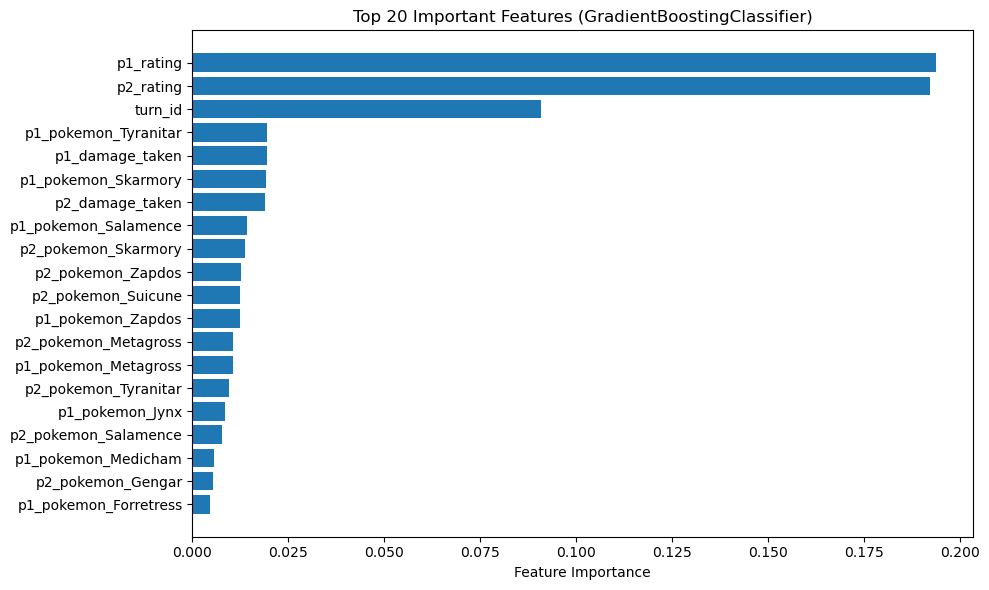

In [29]:
best_gbt = gbtCV.best_estimator_
importances = best_gbt.feature_importances_

feature_names = X_train.columns

indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(20), importances[indices][::-1], align='center')
plt.yticks(range(20), [feature_names[i] for i in indices][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features (GradientBoostingClassifier)')
plt.tight_layout()
plt.show()

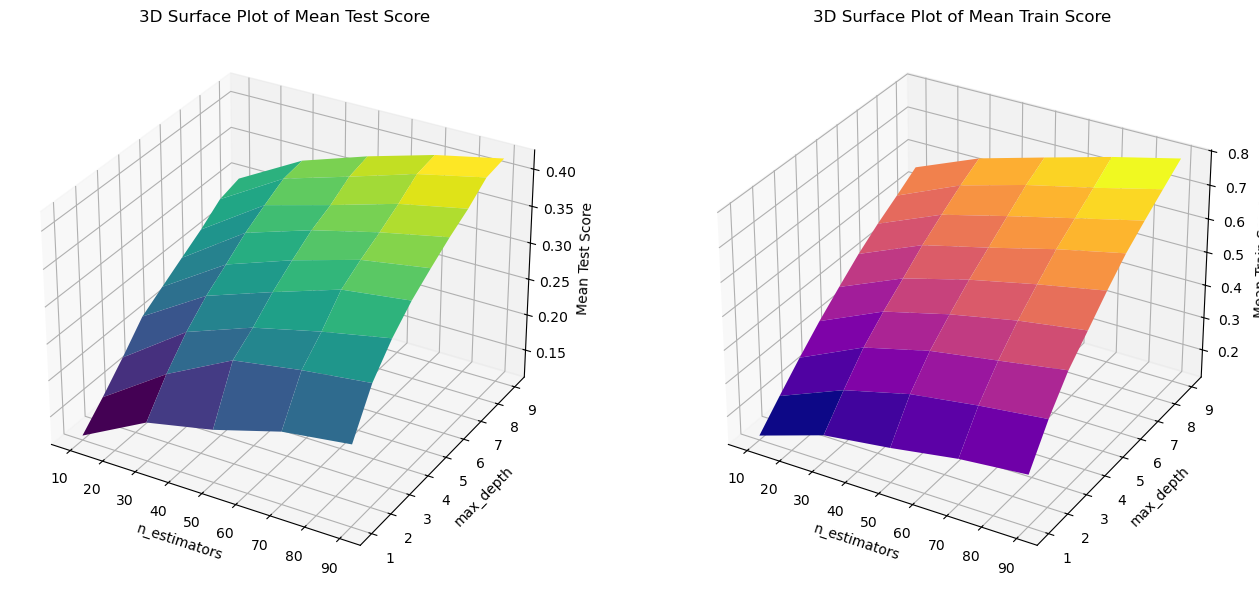

In [47]:
from mpl_toolkits.mplot3d import Axes3D
cv_results = pd.DataFrame(gbtCV.cv_results_)

n_estimators_values = sorted(cv_results['param_n_estimators'].unique())
max_depth_values = sorted(cv_results['param_max_depth'].unique())

mean_test_scores = np.zeros((len(n_estimators_values), len(max_depth_values)))
mean_train_scores = np.zeros((len(n_estimators_values), len(max_depth_values)))

for i, n in enumerate(n_estimators_values):
    for j, d in enumerate(max_depth_values):
        filtered = cv_results[(cv_results['param_n_estimators'] == n) & 
                              (cv_results['param_max_depth'] == d) & 
                              (cv_results['param_learning_rate'] == 0.01)]
        mean_test_scores[i, j] = filtered['mean_test_score'].values[0]
        mean_train_scores[i, j] = filtered['mean_train_score'].values[0]

n_estimators_grid, max_depth_grid = np.meshgrid(n_estimators_values, max_depth_values)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')

ax.plot_surface(n_estimators_grid, max_depth_grid, mean_test_scores.T, cmap='viridis', edgecolor='none')
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('Mean Test Score')
ax.set_title('3D Surface Plot of Mean Test Score')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(n_estimators_grid, max_depth_grid, mean_train_scores.T, cmap='plasma', edgecolor='none')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('max_depth')
ax2.set_zlabel('Mean Train Score')
ax2.set_title('3D Surface Plot of Mean Train Score')

plt.tight_layout()
plt.show()

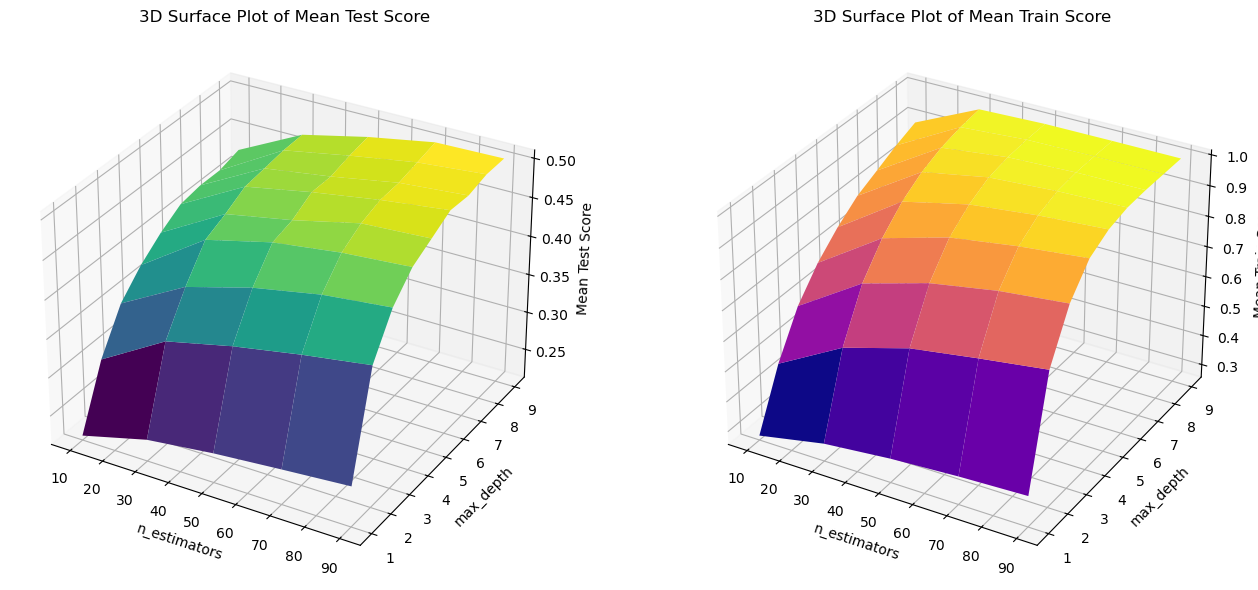

In [49]:
from mpl_toolkits.mplot3d import Axes3D
cv_results = pd.DataFrame(gbtCV.cv_results_)

n_estimators_values = sorted(cv_results['param_n_estimators'].unique())
max_depth_values = sorted(cv_results['param_max_depth'].unique())

mean_test_scores = np.zeros((len(n_estimators_values), len(max_depth_values)))
mean_train_scores = np.zeros((len(n_estimators_values), len(max_depth_values)))

for i, n in enumerate(n_estimators_values):
    for j, d in enumerate(max_depth_values):
        filtered = cv_results[(cv_results['param_n_estimators'] == n) & 
                              (cv_results['param_max_depth'] == d) & 
                              (cv_results['param_learning_rate'] == 0.1)]
        mean_test_scores[i, j] = filtered['mean_test_score'].values[0]
        mean_train_scores[i, j] = filtered['mean_train_score'].values[0]

n_estimators_grid, max_depth_grid = np.meshgrid(n_estimators_values, max_depth_values)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')

ax.plot_surface(n_estimators_grid, max_depth_grid, mean_test_scores.T, cmap='viridis', edgecolor='none')
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('Mean Test Score')
ax.set_title('3D Surface Plot of Mean Test Score')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(n_estimators_grid, max_depth_grid, mean_train_scores.T, cmap='plasma', edgecolor='none')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('max_depth')
ax2.set_zlabel('Mean Train Score')
ax2.set_title('3D Surface Plot of Mean Train Score')

plt.tight_layout()
plt.show()

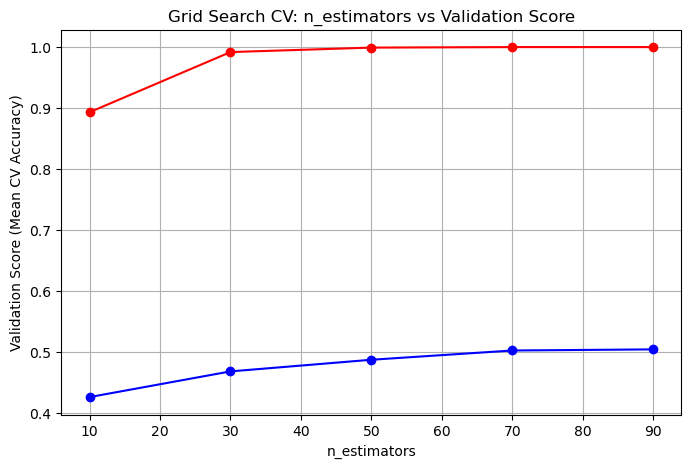

In [53]:
filtered = cv_results[(cv_results['param_learning_rate'] == 0.1) & 
                      (cv_results['param_max_depth'] == 9)]

plt.figure(figsize=(8, 5))
plt.plot(filtered['param_n_estimators'], filtered['mean_test_score'], marker='o', label='Mean Test Score', color='blue')
plt.plot(filtered['param_n_estimators'], filtered['mean_train_score'], marker='o', label='Mean Train Score', color='red')

plt.xlabel('n_estimators')
plt.ylabel('Validation Score (Mean CV Accuracy)')
plt.title('Grid Search CV: n_estimators vs Validation Score')
plt.grid(True)
plt.show()